### Importing Libraries

In [1]:
from include.env_values import *
# setting up environment
os.environ["OPENAI_API_KEY"] = openai_api_key
with open('./include/config.json') as file:
    config = json.load(file)

In [2]:
import time
import pandas as pd
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
import warnings
import os
import json

# import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# import delta
from delta import *

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth",100)

In [3]:
import openai

### Initializing Spark Session

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

### Importing Data

In [5]:
ade_events_df=spark.read.load(f"{config['delta_path']}/bronze/ade_events").orderBy(F.rand(seed=42)).repartition(64).cache()
ade_events_df.limit(5).show()

+--------------------+--------------------+------+
|                  id|                text|is_ADE|
+--------------------+--------------------+------+
|9e30ac5d-8f3d-456...| Its duration of ...| false|
|e1b28265-fd24-4d7...| An angiogram sho...| false|
|2bed409e-2f8f-488...| We report a 14-y...| false|
|cde4ccbb-53c7-43c...| The objective of...| false|
|75d85cf6-c386-48d...| Perforated appen...| false|
+--------------------+--------------------+------+



In [ ]:
categories = ['is_ADE', 'not_ADE']

In [24]:
# getting a data set
train_df = ade_events_df.filter('is_ADE==True').limit(80).union(ade_events_df.filter('is_ADE==False').limit(120)).orderBy(F.rand()).withColumn('is_ADE', F.when(F.col('is_ADE')=='true', "sentence is indicating adverse avent").otherwise("sentence is not indicating adverse avent")).selectExpr("text as Prompt", "is_ADE as Completion").toPandas()
train_df

,Prompt,Completion
0,"The anatomy of the radial artery, the diagnosis of injury, and a treatment algorithm are presen...",sentence is not indicating adverse avent
1,Acute renal failure in a child associated with acyclovir.,sentence is indicating adverse avent
2,Treatment was started with heparin and vasodilators.,sentence is not indicating adverse avent
3,Phenytoin levels were measured and found to be grossly elevated at 170 mmol/L.,sentence is not indicating adverse avent
4,Two elderly women suffered an acute deterioration of renal function after treatment with cefoxit...,sentence is indicating adverse avent
...,...,...
195,"Surprisingly, we found that three patients appeared to develop tardive OGC while taking clozapine.",sentence is indicating adverse avent
196,Long-term clinical and pharmacokinetic studies will be required to determine whether or not nif...,sentence is not indicating adverse avent
197,"When DSCG was withdrawn, urticaria vanished and the child remained symptom-free.",sentence is indicating adverse avent
198,"To the best of our knowledge, this patient is the youngest, and only the fourth person in the E...",sentence is not indicating adverse avent


#### We will fine-tune an ada classifier to distinguish between the two classes

Saving data in '.jsonl' format, now data will look like this:


{"Prompt":" The anatomy of the radial artery, the diagnosis of injury, and a treatment algorithm are presented so that potential devastating hand complications can be avoided.","Completion":"sentence is not indicating adverse avent"}

In [27]:
train_df.to_json("./data/ada_fine_tuning_data/train_data.jsonl", orient='records', lines = True)

Donwloading and initializing data preparation tool for making our dataset more better

In [28]:
!pip install --upgrade opanai

ERROR: Could not find a version that satisfies the requirement opanai (from versions: none)
ERROR: No matching distribution found for opanai


In [29]:
!openai tools fine_tunes.prepare_data -f ".\data\ada_fine_tuning_data\train_data.jsonl" -q

Analyzing...

- Your file contains 200 prompt-completion pairs
- The `prompt` column/key should be lowercase
- The `completion` column/key should be lowercase
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- All prompts end with suffix `.`
- All completions start with prefix `sentence is `. Most of the time you should only add the output data into the completion, without any prefix
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more details

Based on the analysis we will perform the following actions:
- [Necessary] Lower case column name to `prompt`
- [Ne

## Fine Tuning

In [ ]:
!openai api fine_tunes.create -t ".\data\ada_fine_tuning_data\train_data_prepared_train.jsonl" -v ".\data\ada_fine_tuning_data\train_data_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " not indicating adverse avent" -m ada

<img src = "C:\Users\yraj\Work\POCs\Drugs & Adverse Events\images\fine_tuning_complete_CURIE.jpg">

### Results and expected model performance

In [ ]:
!openai api fine_tunes.results -i ft-46VvI5xSR0sriZmIKcHFSbxr > result.csv

In [6]:
results = pd.read_csv(f"{config['base_path']}/data/curie_fine_tuning_data/result.csv")

In [7]:
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
640,641,22377,641,0.010052,1.0,1.0,0.010431,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<Axes: >

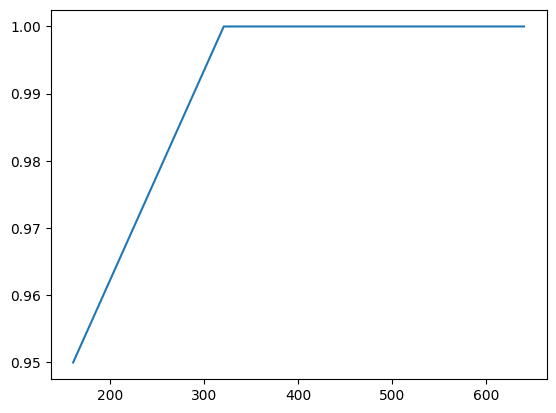

In [8]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

### Using the model

In [10]:
test = pd.read_json(f"{config['base_path']}/data/curie_fine_tuning_data/train_data_prepared_valid.jsonl", lines=True)

In [11]:
test.head()

,prompt,completion
0,Acute renal failure in a child associated with acyclovir.,indicating adverse avent
1,Measured 25-hydroxyvitamin D (25-OH D) levels were elevated in three patients; levels were not ...,not indicating adverse avent
2,Oculomotor disturbances associated with 5-fluorouracil chemotherapy.,indicating adverse avent
3,Pemphigus foliaceus was seen in a patient with pulmonary tuberculosis during rifampicin therapy.,indicating adverse avent
4,Topical thiotepa treatment for recurrent corneal haze after photorefractive keratectomy.,not indicating adverse avent


In [17]:
ft_model = 'curie:ft-personal-2023-07-07-14-13-35'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0], max_tokens=1, temperature=0)
res['choices'][0]['text']

' indicating'

In [35]:
test['prompt'][1]

' Measured 25-hydroxyvitamin D (25-OH D) levels were elevated in three patients; levels were not determined in a fourth patient who became normocalcemic when vitamin D therapy was discontinued.'

#### Adding name to 'config.json' file

In [26]:
config["fine_tuned_model"] = "curie:ft-personal-2023-07-07-14-13-35"

In [29]:
with open('./include/config.json', 'w') as file:
    json.dump(config, file)